In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from visualization_utilities import *
from metadata import *
from utilities2015 import *
from data_manager import *
# from learning_utilities import *

In [3]:
stack = 'MD589'
out_downsample = 8
show_labels = True

# One section

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07242017164220


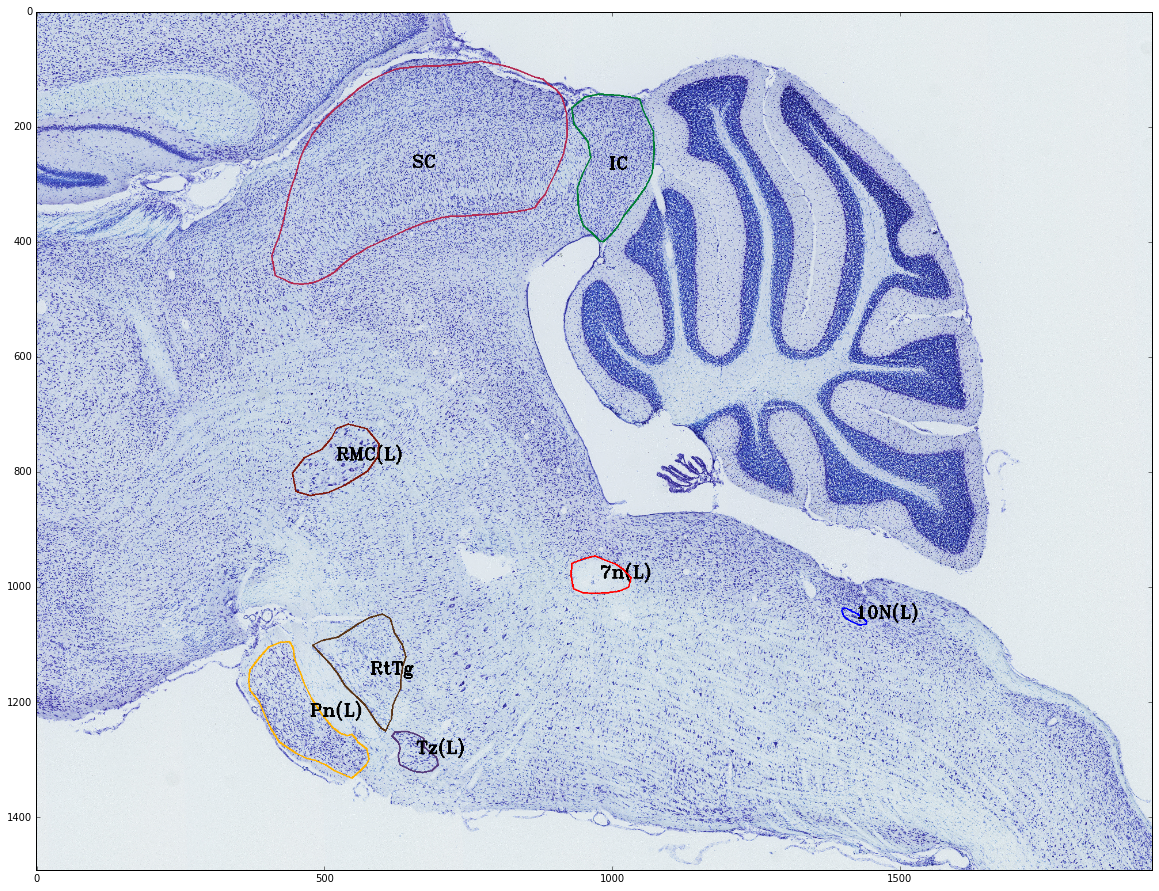

In [24]:
viz = annotation_by_human_overlay_on(bg='original', stack='MD589',
                               sec=200,
                               out_downsample=8, 
                               colors=name_sided_to_color, 
                               show_labels=True,
                               contours=None)

plt.figure(figsize=(20, 20));
plt.imshow(viz);

# Multiple sections

In [22]:
stack = 'MD594'

In [23]:
contours_df = DataManager.load_annotation_v4(stack=stack)
contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
contours = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack)

rm -rf /shared/CSHL_labelings_v3/MD594/MD594_annotation_v3.h5 && mkdir -p /shared/CSHL_labelings_v3/MD594
aws s3 cp s3://mousebrainatlas-data/CSHL_labelings_v3/MD594/MD594_annotation_v3.h5 /shared/CSHL_labelings_v3/MD594/MD594_annotation_v3.h5
rm -rf /shared/CSHL_data_processed/MD594/MD594_transformsTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172.pkl && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_transformsTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172.pkl /shared/CSHL_data_processed/MD594/MD594_transformsTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172.pkl


In [24]:
structure_colors = {n: np.random.randint(0, 255, (3,)) for n in all_known_structures}

In [28]:
classifier_id = 38

/shared/MouseBrainAtlas/utilities/visualization_utilities.py:198: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bg == 'original':


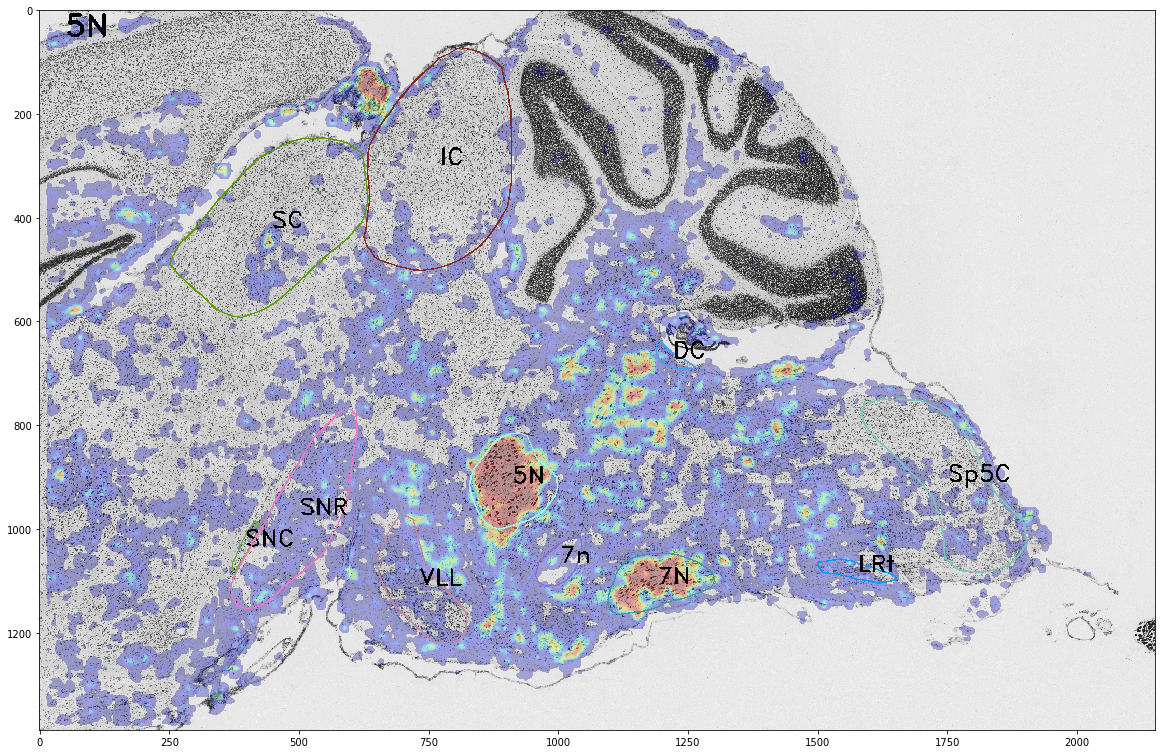

In [35]:
for sec in range(160, 161):
    sc_viz = scoremap_overlay_on(bg='original', stack='MD594',
                              structure='5N',
                                   sec=sec,
                                   out_downscale=8, 
                              classifier_id=classifier_id,
                                   label_text='5N')

#     plt.figure(figsize=(20, 20));
#     plt.imshow(sc_viz);
#     plt.show();
    
    viz = annotation_v4_overlay_on(bg=sc_viz, stack='MD594',
                                   sec=sec,
                                   out_downsample=8, 
                                   colors=structure_colors, 
                                   show_labels=True,
                                   contours=contours)

    plt.figure(figsize=(20, 20));
    plt.imshow(viz);
    plt.show();

In [ ]:
# Read transformed volumes - all structures

volume_downsample = 32 # downsample factor of registered volume.

warped_volumes = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, 
                                                                          stack_f=stack_fixed, 
                                    classifier_setting_m=classifier_setting,
                                    classifier_setting_f=classifier_setting,
                                    warp_setting=warp_setting,
                                                                          downscale=volume_downsample,
                                    trial_idx=None, sided=True)

In [ ]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {0.1: (0,255,255), 
                0.25: (0,255,0), 
                0.5: (255,0,0), 
                0.75: (255,255,0), 
                0.99: (255,0,255)}

# levels = [.5]
# level_colors = {level: (255,0,0) for level in levels}

In [ ]:
downsample_factor = 8 # downsample scale of output image.

In [ ]:
bbox_down32 = \
DataManager.load_original_volume_bbox(stack=stack_fixed, vol_type='score', structure='7N', downscale=32, classifier_setting=classifier_setting)
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = bbox_down32 * 32 / volume_downsample

print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

In [ ]:
t = time.time()
    
    if downsample_factor == 32:
        img = DataManager.load_image(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    else:
        img = DataManager.load_image(stack=stack_fixed, section=sec, resol='lossless', version='cropped_gray_jpeg')
#         img = resize(img, np.array(metadata_cache['image_shape'][stack_fixed][::-1])/downsample_factor)
        img = img[::downsample_factor, ::downsample_factor]
    
    if img.ndim == 2:
        img = gray2rgb(img)
        
    viz = img.copy()
    
    z = int(np.mean(DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=volume_downsample)))
        
    # Find moving volume annotation contours.
    for name_s, vol in warped_volumes.iteritems():
        
        label_pos = None
        
        for level in levels:
            cnts = find_contours(vol[..., z], level=level) # rows, cols
            for cnt in cnts:
                # r,c to x,y
                cnt_on_cropped_volRes = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
                cnt_on_cropped_imgRes = cnt_on_cropped_volRes * volume_downsample / downsample_factor
                cv2.polylines(viz, [cnt_on_cropped_imgRes.astype(np.int)], 
                              True, level_colors[level], contour_width)
                
                if show_text:
                    if label_pos is None:
                        label_pos = np.mean(cnt_on_cropped_imgRes, axis=0)
    
        # Show text 
        if label_pos is not None:
            cv2.putText(viz, name_s, tuple(label_pos.astype(np.int)), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

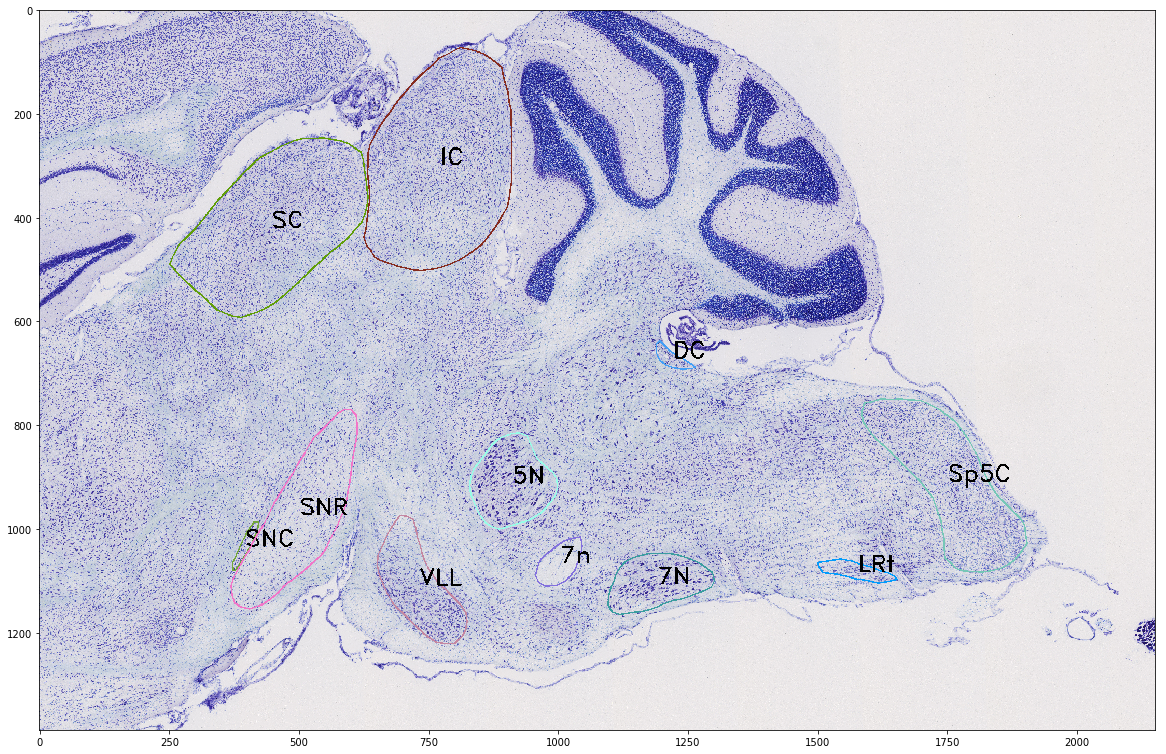

In [36]:
for sec in range(160, 161):

    viz = annotation_v4_overlay_on(bg='original', stack='MD594',
                                   sec=sec,
                                   out_downsample=8, 
                                   colors=structure_colors, 
                                   show_labels=True,
                                   contours=contours)

    plt.figure(figsize=(20, 20));
    plt.imshow(viz);
    plt.show();